### Experiment for Quant-UCB

#### Test for design of upper quantile

Finite arm setting (two arms):  

Arm one: normal distribution with mean 0.72 and variance 1:  
Mean 0.72 Median 0.72  

Arm two: [skewed normal distribution](https://en.wikipedia.org/wiki/Skew_normal_distribution) with skewness 4
Standard skewed normal distribution
$$f(x) = 2\phi(x)\Phi(\alpha x)$$
where $\phi(x)$ is the standard normal pdf, $\Phi(x)$ is the standard normal cdf.  
Mean 0.77 Median 0.67  

Plotting are given below.

#### Selection rule for quantile ucb

$$\text{action} = argmax \quad q_{\alpha_t}(\text{reward})$$
where $q_{\alpha_t}$ is the upper quantile. Some choices of $\alpha_t$ (n is the total number of iterations): 

Inverse: $\alpha_t$ = 1/t  
Linear: $\alpha_t$ = t/n  
Square: $\alpha_t = (t/n)^2$  
Log: $\alpha_t$ = log(t)/n  

#### Definition of the measurement

For multi-armed bandit problem, we usually define:  
best action: choosing the arm with the maximum expected cumulative reward.   
cumulative regret: cumulative reward of best action - cumulative reward of selected action

For quantile ucb, I show the cumulative regret for each upper quantile design vs number of iterations.
To compare, I also show the performance of the ucb1.
The regret is computed as the expected value of 50 experiments, where each experiment has 10000 iterations.

#### Things to discuss

1. How to design experiments? For example, why use skewed distribution here. What properties of quantile-ucb do we want to show according to that? 
2. How to define the best action? why expectation rather than median?
3. How to intepret the plotting results? 

#### Todos
1. Other possible quantile ucb selection rules.
2. CVaR ucb design
3. Compare with quantile ucb and CVaR
4. the case for continuous arms. 

In [1]:
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
import math

In [2]:
# skew normal distribution

NUM_SAMPLES = 100000
SKEW_PARAMS = 4

def rand_skew_norm(fAlpha, fLocation, fScale):
    sigma = fAlpha / np.sqrt(1.0 + fAlpha**2) 

    afRN = np.random.randn(2)
    u0 = afRN[0]
    v = afRN[1]
    u1 = sigma*u0 + np.sqrt(1.0 -sigma**2) * v 

    if u0 >= 0:
        return u1*fScale + fLocation 
    return (-u1)*fScale + fLocation 

def randn_skew(N, skew=0.0):
    return [rand_skew_norm(skew, 0, 1) for x in range(N)]

For normal distribution:
mean: -0.002894, median: -0.001581

For skewed normal distribution:
mean: -0.771539, median: -0.672038

For skewed normal distribution:
mean: 0.777667, median: 0.674412


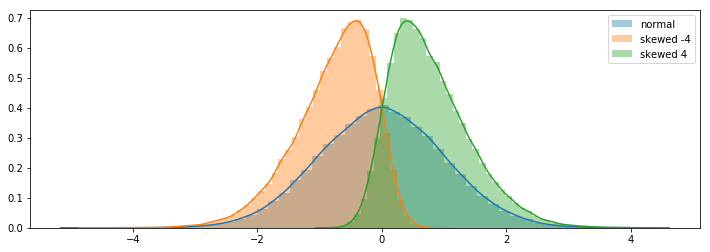

In [3]:
# visualize the simulated arm distribution

plt.subplots(figsize=(12,4))

# normal 
n = np.random.normal(0,1, NUM_SAMPLES)
print('For normal distribution:')
print('mean: %f, median: %f' % (np.mean(n), np.median(n)))

#for alpha_skew in SKEW_PARAMS:
p1 = randn_skew(NUM_SAMPLES, -4)
print()
print('For skewed normal distribution:')
print('mean: %f, median: %f' % (np.mean(p1), np.median(p1)))

#for alpha_skew in SKEW_PARAMS:
p2 = randn_skew(NUM_SAMPLES, 4)
print()
print('For skewed normal distribution:')
print('mean: %f, median: %f' % (np.mean(p2), np.median(p2)))

sns.distplot(n, label = 'normal')
sns.distplot(p1, label = 'skewed -4')
sns.distplot(p2, label = 'skewed 4')
plt.legend()

For normal distribution:
mean: 0.720293, median: 0.719752

For skewed normal distribution:
mean: 0.777667, median: 0.674412


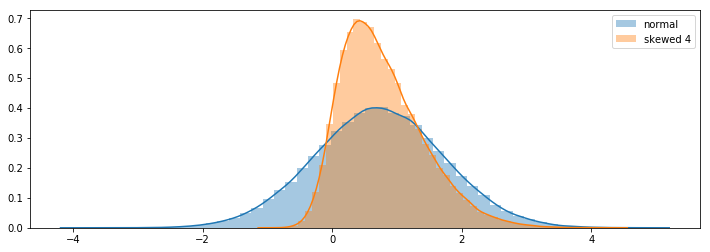

In [4]:
# carefully choose parameters to let skew normal have larger mean and smaller median

plt.subplots(figsize=(12,4))

# normal 
n = np.random.normal(0.72,1, NUM_SAMPLES)
print('For normal distribution:')
print('mean: %f, median: %f' % (np.mean(n), np.median(n)))

#for alpha_skew in SKEW_PARAMS:
p = randn_skew(NUM_SAMPLES, 4)
print()
print('For skewed normal distribution:')
print('mean: %f, median: %f' % (np.mean(p2), np.median(p2)))

sns.distplot(n, label = 'normal')
sns.distplot(p, label = 'skewed 4')
plt.legend()

In [5]:
# settings

num_exper = 50
num_rounds = 5000
loc = 0.72
scale = 1
alpha_skew = 4

In [6]:
def quantile(data, alpha):
    '''
    return the alpha-quantile for given data samples
    '''
    data = np.sort(data)
    idx = int(len(data) * alpha) - 1
    return data[idx]

def CVaR(data, a):
    '''
    return the alpha-CVaR for given data samples
    '''
    data = np.sort(data)
    # idx = int(data.shape[0] * a)
    idx = int(len(data) * a)
    CVaR = np.mean(data[idx:])
    return CVaR


def quant_ucb(num_rounds, loc, scale, alpha_skew, level):
    '''
    Quantile UCB experiment:
    selet the arm with the maximum upper quantile
    the design upper quantile is a function about 'num_rounds' and specified by 'level' function 
    
    Returns the cumulative regret list
    Cumulative regret is defined by the difference of the cumulative reward of the best action 
    (the action with the maximum expected reward) and the cumulative reward of the selected action.
    '''
    rewards = defaultdict(list)
    ucbs = defaultdict(list)
    
    # initialize empirical reward
    rewards['normal'].append(np.random.normal(loc, scale)) 
    rewards['skewed'].append(randn_skew(1, alpha_skew)[0])
    
    # define best action as skewed arm since it has larger expected value
    cumulativeReward = 0
    bestActionCumulativeReward = 0
    Regret_list = []
    selection = []
    
    #for level in quantile_level_choice:
    for i in range(2, num_rounds):
        if quantile(rewards['normal'], level(i, num_rounds)) > quantile(rewards['skewed'], level(i, num_rounds)):
            theReward = np.random.normal(loc, scale, 1)[0]
            rewards['normal'].append(theReward)
            selection.append(1)
            bestActionCumulativeReward += randn_skew(1, alpha_skew)[0]
            #bestActionCumulativeReward += theReward
        else:
            theReward = randn_skew(1, alpha_skew)[0]
            rewards['skewed'].append(theReward)
            selection.append(2)
            bestActionCumulativeReward += theReward
            #bestActionCumulativeReward += np.random.normal(loc, scale, 1)[0]
        cumulativeReward += theReward
        regret = bestActionCumulativeReward - cumulativeReward
        Regret_list.append(regret)
            
    return Regret_list, selection

In [7]:
# Report the how cumulative reward changed in terms of different alpha level design

Regret_dict = defaultdict(list)
selection_dict = defaultdict(list)

def inverse(t, num_rounds):
    if t == 0:
        return 0
    else:
        return 1.0/(t)
def linear(t, num_rounds):
    return float(t)/num_rounds
def linear_limit(t, num_rounds):
    q = float(t)/num_rounds
    if q <= 0.5:
        return q
    else: 
        return 0.5
def square(t, num_rounds):
    return float(t ** 2)/num_rounds ** 2
def square_limit(t, num_rounds):
    q = float(t ** 2)/num_rounds ** 2
    if q <= 0.5:
        return q
    else: 
        return 0.5
def log(t, num_rounds):
    return np.log(t + 1)/num_rounds

level_list = [inverse, linear, linear_limit, square, square_limit, log]
level_name = ['inverse', 'linear', 'linear_limit', 'square', 'square_limit', 'log']

for exper in range(num_exper):
    for i, level in enumerate(level_list):
        regret, selection = quant_ucb(num_rounds, loc, scale, alpha_skew, level)
        Regret_dict[level_name[i]].append(regret)
        selection_dict[level_name[i]].append(selection)
        #Regret_list = quant_ucb(num_rounds, loc, scale, alpha_skew, level)

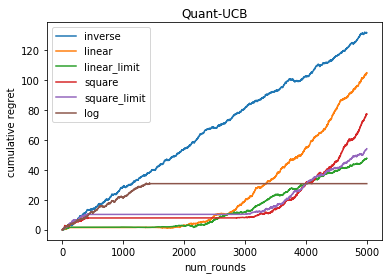

In [8]:
for key, value in Regret_dict.items():
    value = np.asarray(value)
    ave_regret = np.average(value, axis = 0)
    plt.plot(ave_regret, label = key)
    
plt.ylabel('cumulative regret')
plt.xlabel('num_rounds')
plt.title('Quant-UCB')
plt.legend()

Why 'linear' and 'square' design first sticking on the best arm but end up with having regret increasing continuely?

-- limiting the quantile level below to 0.5 controls the regret increasing. 

Why 'log' design has a stable regret after 1000 iterations? Is that true for other datasets?

In [9]:
# compare with UCB1 algorithm

def upperBound(step, numPlays):
    return math.sqrt(2 * math.log(step + 1) / numPlays)

def ucb1(num_rounds, loc, scale, alpha_skew):
    rewards = {}
    numPlays = {}
    
    # initialize empirical reward
    rewards['normal'] = np.random.normal(loc, scale, 1)[0]
    rewards['skewed'] = randn_skew(1, alpha_skew)[0]
    numPlays['normal'] = 1
    numPlays['skewed'] = 1

    # define best action as skewed arm since it has larger expected value
    cumulativeReward = 0
    bestActionCumulativeReward = 0
    Regret_list = []
    selected_action = []

    for i in range(2, num_rounds):
        if rewards['normal']/numPlays['normal'] + upperBound(i, numPlays['normal']) \
                > rewards['skewed']/numPlays['skewed'] + upperBound(i, numPlays['skewed']):
            theReward = np.random.normal(loc, scale, 1)[0]
            numPlays['normal'] += 1
            rewards['normal'] += theReward
            bestActionCumulativeReward += randn_skew(1, alpha_skew)[0]
            #bestActionCumulativeReward += theReward
            selected_action.append(1)
        else:
            theReward = randn_skew(1, alpha_skew)[0]
            numPlays['skewed'] += 1
            rewards['skewed']+= theReward
            bestActionCumulativeReward += theReward
            #bestActionCumulativeReward += np.random.normal(loc, scale, 1)[0]
            selected_action.append(2)
        cumulativeReward += theReward
        regret = bestActionCumulativeReward - cumulativeReward
        Regret_list.append(regret)

    return Regret_list, selected_action 

#Regret_list = ucb1(num_rounds, loc, scale, alpha_skew)

In [10]:
Regret_list = []

for exper in range(num_exper):
    for i, level in enumerate(level_list):
        regret, selected_action = ucb1(num_rounds, loc, scale, alpha_skew)
        Regret_list.append(regret)
        #print(selected_action)
        #Regret_list = quant_ucb(num_rounds, loc, scale, alpha_skew, level)
    
regret = np.asarray(Regret_list)
ave_regret = np.average(regret, axis = 0)
#plt.plot(ave_regret)


/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


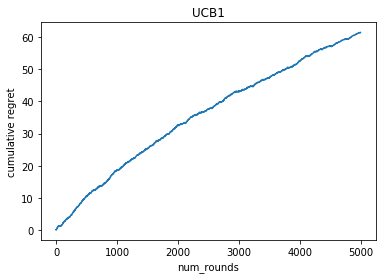

In [11]:
plt.plot(ave_regret)
plt.ylabel('cumulative regret')
plt.xlabel('num_rounds')
plt.title('UCB1')
    
plt.legend()